Mike and Spencer

### Beyond the Emergency Department: Predictive Analytics for 6-Month Patient Admission in Harmony Healthcare

### Problem Statement

Our goal is to build a predictive model that identifies whether a patient will experience at least one ED admission within the next six months. Based on instructor feedback, we removed columns directly tied to emergency department data, forcing the model to learn broader risk signals rather than simply reproducing ED activity. This notebook documents data cleaning, exploratory visualization, and an initial predictive model using forward feature selection with logistic regression.

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
# Then, update the path in pd.read_excel, for example:
df = pd.read_excel('/content/drive/MyDrive/Data Science CSC 108/HarmonyHealthcareOneWeek_9_2025.xlsx')

#df = pd.read_excel('HarmonyHealthcareOneWeek_9_2025.xlsx')

# We want to keep the 'ED Episode Admit Last-6-Mths' column and remove all other columns with ED in the name
ed_columns = [col for col in df.columns if 'ED' in col and col != 'ED Episode Admit Last-6-Mths']
df = df.drop(columns=ed_columns)

# Assuming NaN in 'ED Episode Admit Last-6-Mths' means no admission, fill with 0 early
target = 'ED Episode Admit Last-6-Mths'
df[target] = df[target].fillna(0)

# Now we can remove any columns that are just empty to shrink the data further
df = df.dropna(axis=1, how='all')
df.head()

Mounted at /content/drive


,Age,EHR Sex,ED Episode Admit Last-6-Mths,Most Recent Encounter Type,UDS Qualifying Encounter Count,UDS Homelessness Status,IP Episode Admit Date,IP Episode Admit Location,IP Episode Admit Readmit,IP Episode Admit Past-6-Mths,...,Urine Creatinine Date,Urine Creatinine Code,Urine Creatinine Result,Varicella Titer Date,Varicella Titer Code,Varicella Titer Result,Violence Screening Date,Violence Screening Type,Vision Screening Date,Vision Screening Code
0,26,male,0.0,TeleBHTher,21.0,Not Homeless,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,2025-02-10,Domestic Violence PRAPARE,2024-11-08,99173
1,14,female,0.0,Nutrition,4.0,Not Homeless,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2025-01-02,99173
2,11,male,0.0,F/U,5.0,Not Homeless,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,2024-11-09,99173
3,49,male,0.0,BH Therapy,48.0,Not Homeless,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,2025-08-26,Domestic Violence PRAPARE,2024-09-25,99173
4,39,female,0.0,Telemed,4.0,Not Homeless,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaN,NaN,2025-07-26,Domestic Violence PRAPARE,2025-06-24,99173


In [2]:
target = 'ED Episode Admit Last-6-Mths' # Store our target var so we can use it later

# Check target distribution
print(df[target].value_counts())
print(df[target].value_counts(normalize=True) * 100)

# Check missing percentages
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

ED Episode Admit Last-6-Mths
0.0     2442
1.0      170
2.0       39
3.0       10
4.0        4
5.0        4
6.0        1
34.0       1
7.0        1
Name: count, dtype: int64
ED Episode Admit Last-6-Mths
0.0     91.392216
1.0      6.362275
2.0      1.459581
3.0      0.374251
4.0      0.149701
5.0      0.149701
6.0      0.037425
34.0     0.037425
7.0      0.037425
Name: proportion, dtype: float64
Stress ICD10-Code                     99.962575
AntiCoag Med Stop Date                99.962575
Anticoag Medication Stop Date         99.962575
Stress ICD10-Date                     99.962575
PrEP Medication Stop Date             99.962575
                                        ...    
SDOH Triggers                          0.898204
Patient Appointment No-Show Rate %     0.149701
Patient Appointment No-Show Count      0.149701
Patient Medicaid Risk Risk Gap         0.074850
Patient Medicaid Risk Total Risk       0.074850
Length: 561, dtype: float64


In [3]:
# Drop columns with >70% missing, except target
columns_to_drop = [c for c in df.columns if c != target and df[c].isna().mean() * 100 > 70]
print("Number of columns to drop:", len(columns_to_drop))
df = df.drop(columns=columns_to_drop)
df.head()

Number of columns to drop: 417


,Age,EHR Sex,ED Episode Admit Last-6-Mths,Most Recent Encounter Type,UDS Qualifying Encounter Count,UDS Homelessness Status,Active Medications,Alcohol Assessment Date,Alcohol Assessment Code,Alcohol Assessment Result,...,Stress Response,Transportation Trigger,Transportation NonMed-Date,Transportation NonMed-Reponse,UDS SDOH Triggers,UDS SDOH Tally,Violence Screening Date,Violence Screening Type,Vision Screening Date,Vision Screening Code
0,26,male,0.0,TeleBHTher,21.0,Not Homeless,13,2024-12-06,AUDIT-C,0.0,...,Not at all,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,2025-02-10,Domestic Violence PRAPARE,2024-11-08,99173
1,14,female,0.0,Nutrition,4.0,Not Homeless,11,2025-09-17,AUDIT-C,0.0,...,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaT,NaN,2025-01-02,99173
2,11,male,0.0,F/U,5.0,Not Homeless,23,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,FINANCIAL STRAIN,1.0,NaT,NaN,2024-11-09,99173
3,49,male,0.0,BH Therapy,48.0,Not Homeless,23,2024-06-05,AUDIT-C,3.0,...,Not at all,N,8/26/2025 12:00:00 AM,N,FINANCIAL STRAIN FOOD,2.0,2025-08-26,Domestic Violence PRAPARE,2024-09-25,99173
4,39,female,0.0,Telemed,4.0,Not Homeless,4,2024-10-30,AUDIT-C,0.0,...,A little bit,N,7/26/2025 12:00:00 AM,N,FINANCIAL STRAIN,1.0,2025-07-26,Domestic Violence PRAPARE,2025-06-24,99173


In [4]:
# Impute missing values + encode categoricals

from sklearn.impute import SimpleImputer

target_col = 'ED Episode Admit Last-6-Mths' # Define target here too for consistency

# Separate numerical + categorical
numeric_cols = df.select_dtypes(include='number').columns.tolist()
# Exclude the target column from numeric imputation
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute numerics with median
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Impute categoricals with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Columns: 7049 entries, Age to Vision Screening Code_Z01.01
dtypes: bool(6970), datetime64[ns](40), float64(39)
memory usage: 19.4 MB


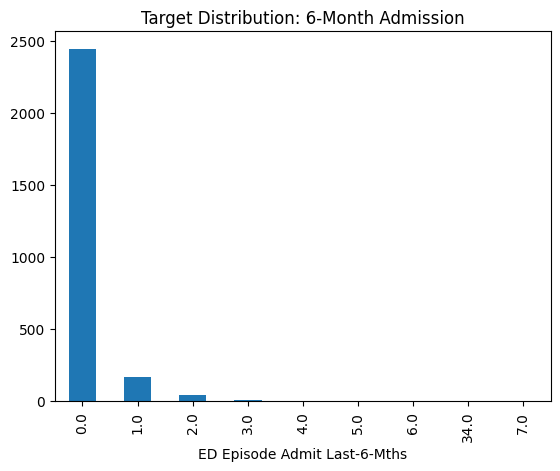

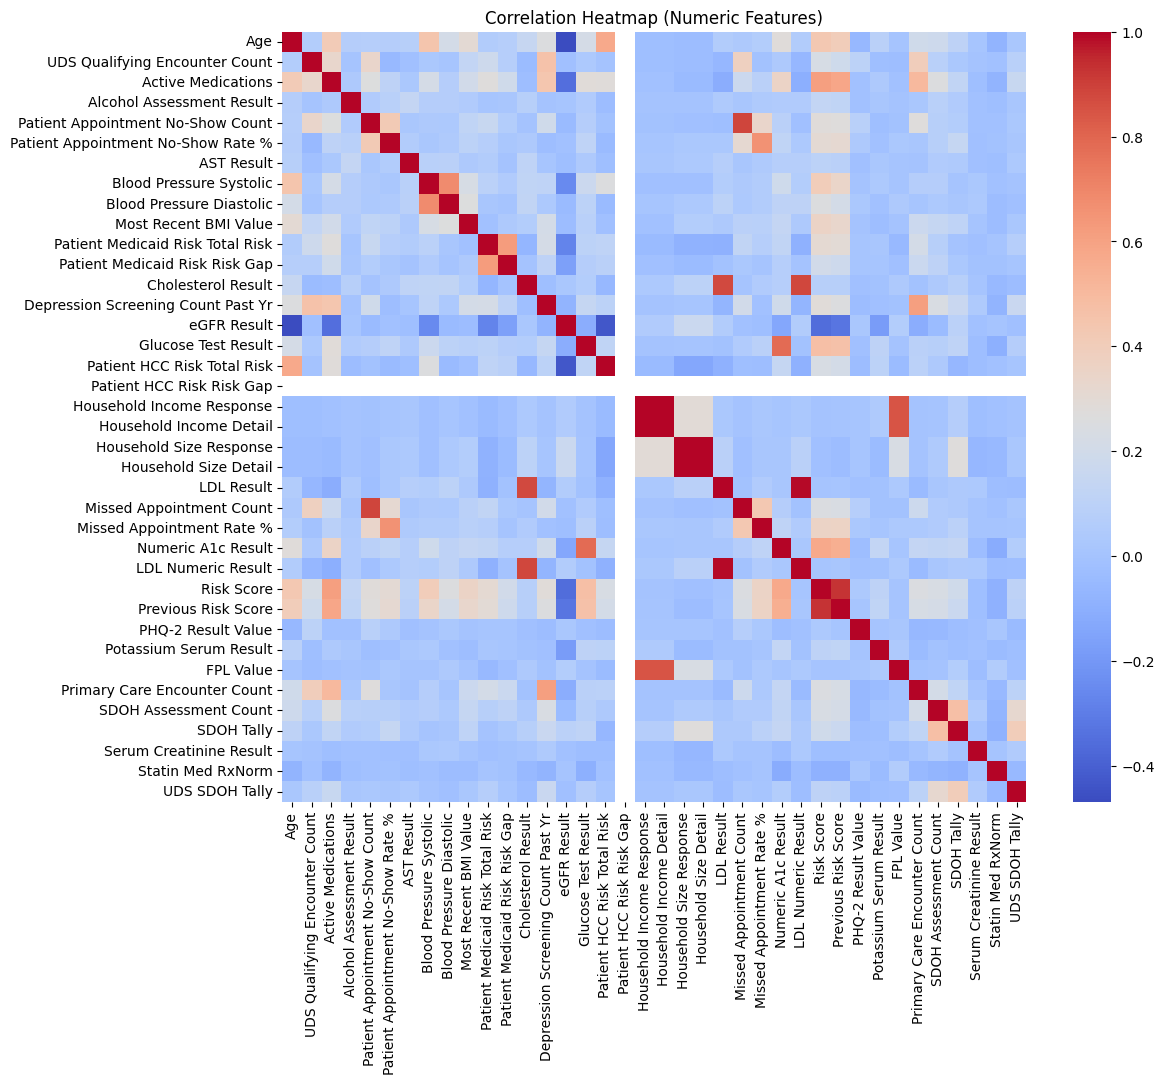

In [5]:
# Visualizations!

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Target distribution
df[target].value_counts().plot(kind='bar')
plt.title("Target Distribution: 6-Month Admission")
plt.show()

# 2. Histogram of top numeric features
# df[numeric_cols].hist(figsize=(12,10))
# plt.tight_layout()
# plt.show()

# 3. Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [6]:
# Convert target to binary (admitted = 1 if >0)
y = (df[target] > 0).astype(int)
X = df.drop(columns=[target])

In [7]:
# Clean and prepare data

# Make a copy of the dataframe to avoid modifying the original `df` from the previous cell.
df_processed = df.copy()

# Target column name
target_col_name = "ED Episode Admit Last-6-Mths"

# Isolate the target variable BEFORE any potentially destructive transformations.
# Apply fillna(0) and >0 to ensure binary classification, and then convert to int.
y = (df_processed[target_col_name].fillna(0) > 0).astype(int)

# Drop the target column from the feature set X
X = df_processed.drop(columns=[target_col_name])

# Identify columns that are actual datetime objects in X.
# These are the columns from `df.info()` with dtypes `datetime64[ns]` from the previous step.
datetime_cols_in_X = X.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Convert identified datetime columns in X to numeric days since epoch.
# This avoids incorrectly converting other numeric columns.
for col in datetime_cols_in_X:
    X[col] = (X[col] - pd.Timestamp("1970-01-01")).dt.days

# Replace remaining missing numerical values in X with column medians.
# This imputation step is for the features (X) after date conversion.
X = X.fillna(X.median(numeric_only=True))

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Logistic Regression + evaluation function
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def evaluate(feature_list):
    idxs = [X.columns.get_loc(f) for f in feature_list]

    model = LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    )

    model.fit(X_train_scaled[:, idxs], y_train)

    preds = model.predict_proba(X_test_scaled[:, idxs])[:, 1]

    return roc_auc_score(y_test, preds)

In [9]:
# Greedy forward feature selection

# Initialize lists: 'remaining' holds features not yet selected, 'selected' holds chosen features,
# and 'scores' stores the AUC for the selected feature set at each step.
remaining = list(X.columns)
selected = []
scores = []

# Perform 10 steps of forward feature selection.
# In each step, we find the single best feature to add to our 'selected' set.
for step in range(10):
    best_feature = None
    best_auc = -1 # Initialize with a low AUC score to ensure the first valid AUC is higher

    # Iterate through all features not yet selected to find the one that maximizes AUC when added.
    for feat in remaining:
        # Create a temporary list of features that includes currently selected features plus one 'candidate' feature.
        try_features = selected + [feat]
        # Evaluate the performance (AUC) of the model using this candidate set of features.
        auc = evaluate(try_features)

        # If this candidate set yields a better AUC than the current best, update best_auc and best_feature.
        if auc > best_auc:
            best_auc = auc
            best_feature = feat

    # Add the best performing feature from this step to the 'selected' list.
    selected.append(best_feature)
    # Record the AUC achieved with this new set of selected features.
    scores.append(best_auc)
    # Remove the selected feature from the 'remaining' list so it's not considered again.
    remaining.remove(best_feature)

    # Print the result for the current step.
    print(f"Step {step+1}: Selected {best_feature} — AUC {best_auc:.4f}")

# After all steps are complete, print the final list of top 10 selected features and their corresponding AUC scores.
print("\nTop 10 selected features:")
for i, (feat, auc) in enumerate(zip(selected, scores), 1):
    print(f"{i}. {feat} — AUC {auc:.4f}")

Step 1: Selected Depression Screening Count Past Yr — AUC 0.6041
Step 2: Selected Age — AUC 0.6427
Step 3: Selected Insurance Primary Payer_HealthFirst MCR — AUC 0.6774
Step 4: Selected Colorectal Cancer Screening Status Next Due_05/05/2028 — AUC 0.7006
Step 5: Selected Insurance Primary Payer_HealthFirst MCD — AUC 0.7161
Step 6: Selected eGFR Date — AUC 0.7434
Step 7: Selected SDOH Triggers_FPL<200% HISP/LAT  — AUC 0.7624
Step 8: Selected Sexually Active Detail_Pap Test — AUC 0.7767
Step 9: Selected Insurance Primary Payer_HealthFirst Essential Tier 3-4 — AUC 0.7881
Step 10: Selected SDOH Triggers_FPL<200% INSURANCE RACE  — AUC 0.7979

Top 10 selected features:
1. Depression Screening Count Past Yr — AUC 0.6041
2. Age — AUC 0.6427
3. Insurance Primary Payer_HealthFirst MCR — AUC 0.6774
4. Colorectal Cancer Screening Status Next Due_05/05/2028 — AUC 0.7006
5. Insurance Primary Payer_HealthFirst MCD — AUC 0.7161
6. eGFR Date — AUC 0.7434
7. SDOH Triggers_FPL<200% HISP/LAT  — AUC 0.7624


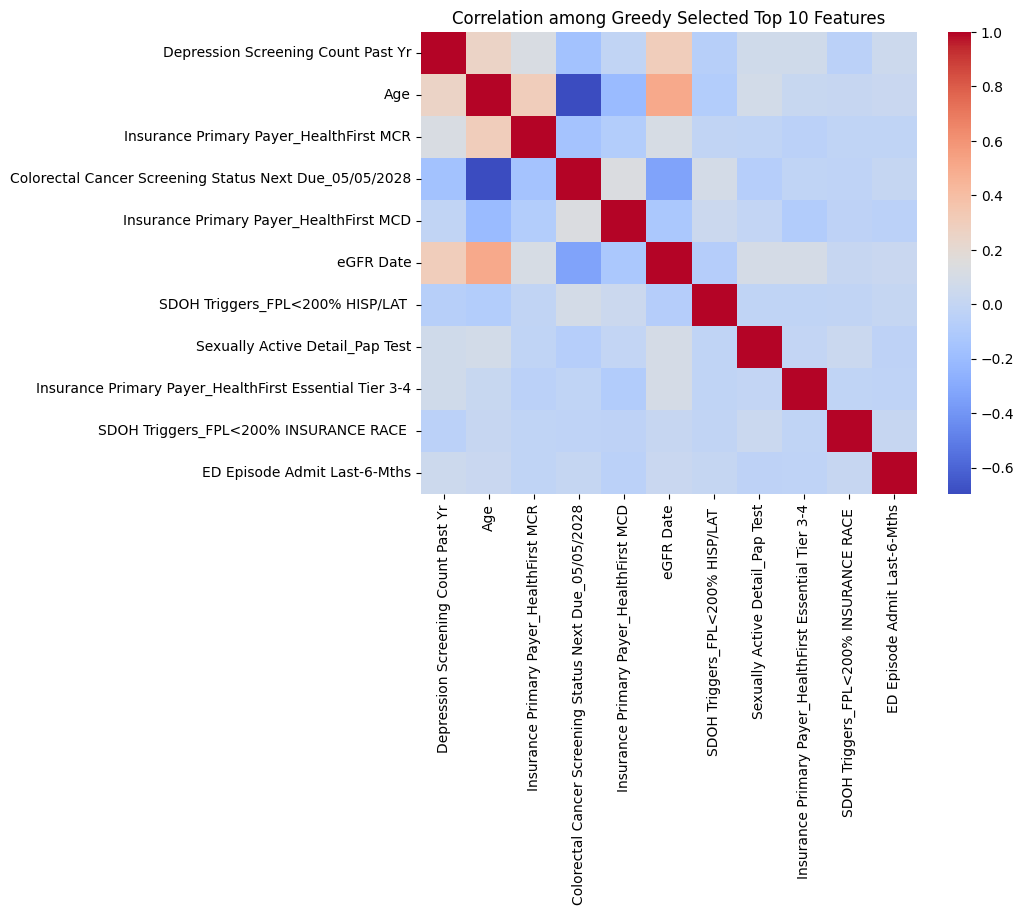

In [10]:
# Are the top 10 selected features correlated to each other?
selected_df = df[selected + [target]]
corr = selected_df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation among Greedy Selected Top 10 Features")
plt.show()


In [11]:
# 5 fold Cross-Validation

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

# Use only the greedy-selected top 10 features
X_selected = X[selected]

# Build pipeline to avoid data leakage
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=500,
        class_weight="balanced"
    ))
])

# 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline,
    X_selected,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("5-fold CV AUC scores:", cv_scores)
print("Mean CV AUC:", np.mean(cv_scores))
print("Std CV AUC:", np.std(cv_scores))


5-fold CV AUC scores: [0.68916155 0.64506091 0.62047844 0.66932466 0.68208749]
Mean CV AUC: 0.6612226101823874
Std CV AUC: 0.025309521026617293


### Discussion of Early Results and Moving Forward

* The greedy selection approach identified a ranked set of features contributing incremental predictive value.
* The AUC values supply an interpretable measure of classification.
* Further improvements planned include:
    1. Cross validate the model with testing data
    2. Plot the AUC for more than 10 features
    3. Check correlation of selected features to make sure we are not selecting highly correlated features
    4. Attempt to compare to Lasso if enough time

The project was a collaborative effort between Mike and Spencer with both of us working on the data cleaning step and Mike taking charge of the algorithm and Spencer doing the write up and github steps. What remains is a little of a first come first serve effort with communication being key to make sure we don't step on each others toes.

Github link: https://github.com/99x5zbrvgj-droid/CSC108HHCFinal